In [1]:
!unzip data.zip
%ls

Archive:  data.zip
   creating: data/
   creating: data/normal/
  inflating: data/normal/1.jpg       
  inflating: data/normal/10.jpg      
  inflating: data/normal/100.jpg     
  inflating: data/normal/11.jpg      
  inflating: data/normal/12.jpg      
  inflating: data/normal/13.jpg      
  inflating: data/normal/14.jpg      
  inflating: data/normal/15.jpg      
  inflating: data/normal/16.jpg      
  inflating: data/normal/17.jpg      
  inflating: data/normal/18.jpg      
  inflating: data/normal/19.jpg      
  inflating: data/normal/2.jpg       
  inflating: data/normal/20.jpg      
  inflating: data/normal/21.jpg      
  inflating: data/normal/22.jpg      
  inflating: data/normal/23.jpg      
  inflating: data/normal/24.jpg      
  inflating: data/normal/25.jpg      
  inflating: data/normal/26.jpg      
  inflating: data/normal/27.jpg      
  inflating: data/normal/28.jpg      
  inflating: data/normal/29.jpg      
  inflating: data/normal/3.jpg       
  inflating: data/normal

In [2]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import tensorflow as tf


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from PIL import Image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.images, self.labels = [], []
        for dirpath, _, filenames in os.walk(dataset_dir):
            for filename in filenames:
                label = 0 if 'normal' in dirpath else 1
                img_path = os.path.join(dirpath, filename)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [4]:
data_dir = '/content/data'
dataset = ImageDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
from tqdm import tqdm

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

def train_and_evaluate(model_name, model, dataset, train_transform, val_transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model_dir = f"models/{model_name}"
    os.makedirs(model_dir, exist_ok=True)

    all_train_losses, all_test_losses = [], []
    all_train_accs, all_test_accs = [], []
    all_fprs, all_tprs, roc_aucs = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold+1}/{k_folds} for {model_name}')
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_subset.dataset.transform = train_transform
        test_subset.dataset.transform = val_transform

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

        best_acc = 0.0
        for epoch in tqdm(range(10), desc=f"Training {model_name} Fold {fold+1}"):
            model.train()
            running_loss, correct = 0.0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

            epoch_acc = correct / len(train_subset)
            all_train_losses.append(running_loss / len(train_subset))
            all_train_accs.append(epoch_acc)

            model.eval()
            correct, total, test_loss = 0, 0, 0.0
            all_preds, all_targets = [], []
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * inputs.size(0)
                    correct += (outputs.argmax(1) == labels).sum().item()
                    total += labels.size(0)
                    all_preds.extend(outputs.softmax(1)[:, 1].cpu().numpy())
                    all_targets.extend(labels.cpu().numpy())

            epoch_test_acc = correct / total
            all_test_losses.append(test_loss / total)
            all_test_accs.append(epoch_test_acc)

            fpr, tpr, _ = roc_curve(all_targets, all_preds)
            all_fprs.append(fpr)
            all_tprs.append(tpr)
            roc_aucs.append(auc(fpr, tpr))

            if epoch_test_acc > best_acc:
                best_acc = epoch_test_acc
                torch.save(model.state_dict(), f"{model_dir}/best_model_fold_{fold}.pth")

    torch.save(model.state_dict(), f"{model_dir}/final_model.pth")

    return all_train_losses, all_test_losses, all_train_accs, all_test_accs, all_fprs, all_tprs, roc_aucs

In [8]:
models_dict = {
    'MobileNetV2': models.mobilenet_v2(weights='IMAGENET1K_V2'),
    'MobileNetV3': models.mobilenet_v3_large(weights='IMAGENET1K_V2'),
    'ShuffleNetV2': models.shufflenet_v2_x1_0(weights='IMAGENET1K_V1'),
    'VisionTransformer': models.vit_b_16(weights='IMAGENET1K_V1')
}

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 38.9MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 136MB/s] 
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 81.7MB/s]
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 219MB/s]


In [9]:
results = {}
for model_name, model in tqdm(models_dict.items(), desc="Training Models"):
    print(f"Training {model_name}")
    results[model_name] = train_and_evaluate(model_name, model, dataset, train_transform, val_transform)


Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

Training MobileNetV2
Fold 1/5 for MobileNetV2



Training MobileNetV2 Fold 1: 100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


Fold 2/5 for MobileNetV2



Training MobileNetV2 Fold 2: 100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


Fold 3/5 for MobileNetV2



Training MobileNetV2 Fold 3: 100%|██████████| 10/10 [01:39<00:00,  9.94s/it]


Fold 4/5 for MobileNetV2



Training MobileNetV2 Fold 4: 100%|██████████| 10/10 [01:39<00:00,  9.93s/it]


Fold 5/5 for MobileNetV2



Training Models:  25%|██▌       | 1/4 [08:19<24:59, 499.84s/it]

Training MobileNetV3
Fold 1/5 for MobileNetV3



Training MobileNetV3 Fold 1: 100%|██████████| 10/10 [01:40<00:00, 10.02s/it]


Fold 2/5 for MobileNetV3



Training MobileNetV3 Fold 2: 100%|██████████| 10/10 [01:39<00:00,  9.99s/it]


Fold 3/5 for MobileNetV3



Training MobileNetV3 Fold 3: 100%|██████████| 10/10 [01:39<00:00,  9.98s/it]


Fold 4/5 for MobileNetV3



Training MobileNetV3 Fold 4: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


Fold 5/5 for MobileNetV3



Training Models:  50%|█████     | 2/4 [16:40<16:40, 500.05s/it]

Training ShuffleNetV2
Fold 1/5 for ShuffleNetV2



Training ShuffleNetV2 Fold 1: 100%|██████████| 10/10 [01:39<00:00,  9.95s/it]


Fold 2/5 for ShuffleNetV2



Training ShuffleNetV2 Fold 2: 100%|██████████| 10/10 [01:38<00:00,  9.89s/it]


Fold 3/5 for ShuffleNetV2



Training ShuffleNetV2 Fold 3: 100%|██████████| 10/10 [01:38<00:00,  9.88s/it]


Fold 4/5 for ShuffleNetV2



Training ShuffleNetV2 Fold 4: 100%|██████████| 10/10 [01:38<00:00,  9.88s/it]


Fold 5/5 for ShuffleNetV2



Training Models:  75%|███████▌  | 3/4 [24:54<08:17, 497.64s/it]

Training VisionTransformer
Fold 1/5 for VisionTransformer



Training VisionTransformer Fold 1: 100%|██████████| 10/10 [01:53<00:00, 11.36s/it]


Fold 2/5 for VisionTransformer



Training VisionTransformer Fold 2: 100%|██████████| 10/10 [01:52<00:00, 11.22s/it]


Fold 3/5 for VisionTransformer



Training VisionTransformer Fold 3: 100%|██████████| 10/10 [01:53<00:00, 11.38s/it]


Fold 4/5 for VisionTransformer



Training VisionTransformer Fold 4: 100%|██████████| 10/10 [01:55<00:00, 11.53s/it]


Fold 5/5 for VisionTransformer



Training Models: 100%|██████████| 4/4 [34:22<00:00, 515.66s/it]


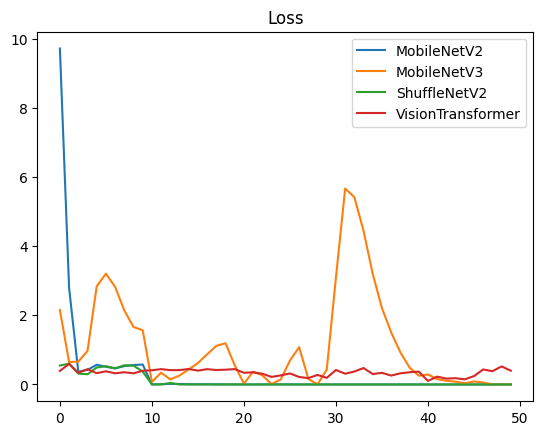

In [10]:
plt.figure()
for model_name, (train_losses, test_losses, train_accs, test_accs, fprs, tprs, roc_aucs) in results.items():
    plt.plot(test_losses, label=model_name)
plt.legend()
plt.title("Loss")
plt.show()

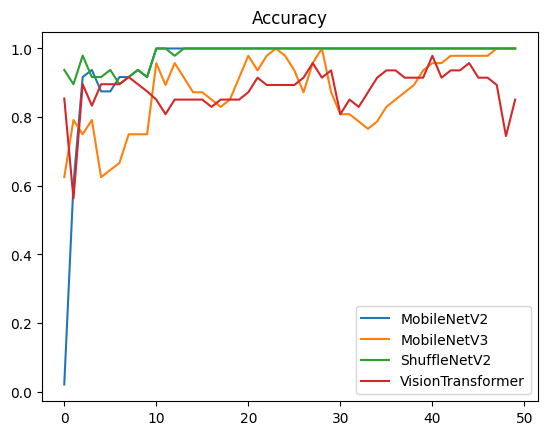

In [11]:
plt.figure()
for model_name, (train_losses, test_losses, train_accs, test_accs, fprs, tprs, roc_aucs) in results.items():
    plt.plot(test_accs, label=model_name)
plt.legend()
plt.title("Accuracy")
plt.show()


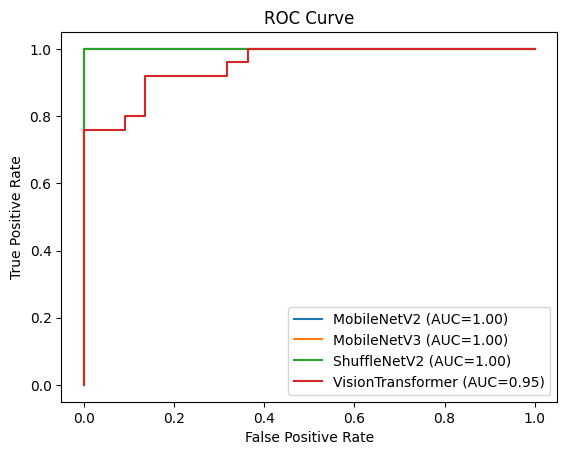

In [12]:
plt.figure()
for model_name, (train_losses, test_losses, train_accs, test_accs, fprs, tprs, roc_aucs) in results.items():
    plt.plot(fprs[-1], tprs[-1], label=f"{model_name} (AUC={roc_aucs[-1]:.2f})")
plt.legend()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
